<a href="https://colab.research.google.com/github/hscrown/madatpublicdata/blob/main/KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 모듈과 패키지 인스톨과 임포트


In [3]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162998 sha256=1cfc3b2fe787b0a01d5670e4f4396a4cf4d9189f59a0638c9fd16bbfea0a9cee
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from surprise import Dataset, Reader
from surprise import KNNWithMeans
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split
from surprise.model_selection import GridSearchCV

# 데이터로드 및 전처리

In [6]:
df = pd.read_csv('/content/user_place_data_240429.csv')

In [8]:
# 정수인코딩하기 # 도서관은 0 , 박물관은 1, 공원은 2 로 매핑
muse = pd.read_csv('/content/seoul_museums.csv')
muse = muse[['시설명','위도','경도']]

parks = pd.read_csv('/content/seoul_parks.csv')
parks = parks[['공원명','Y좌표(WGS84)','X좌표(WGS84)']]
# ['시설명','위도','경도']로 컬럼명 변경
parks.columns = ['시설명','위도','경도']

libs = pd.read_csv('/content/seoul_libs.csv')
libs = libs[['도서관명','위도','경도']]
libs.columns = ['시설명','위도','경도']

# df2에 합치기
df2 = pd.concat([muse,parks,libs])

# df2에 Place Type 컬럼 만들고, 도서관은 0, 박물관은 1, 공원은 2로 매핑
df2['Place Type'] = 0
df2.loc[df2['시설명'].isin(muse['시설명']), 'Place Type'] = 1
df2.loc[df2['시설명'].isin(parks['시설명']), 'Place Type'] = 2

# df2 컬럼명 변경
df2.columns = ['Place Name','Latitude','Longitude','Place Type']

In [9]:
# df에 df2 머지 # 이너조인
df = pd.merge(df, df2, on='Place Name' , how='inner')

In [10]:
df

,User Id,Place Id,Rating,Place Name,Latitude,Longitude,Place Type
0,1685,34,1,길동생태공원,37.540394,127.154779,2
1,1166,34,5,길동생태공원,37.540394,127.154779,2
2,936,34,3,길동생태공원,37.540394,127.154779,2
3,82,34,4,길동생태공원,37.540394,127.154779,2
4,757,34,1,길동생태공원,37.540394,127.154779,2
...,...,...,...,...,...,...,...
4475,482,159,1,중랑상봉도서관,37.593096,127.078711,0
4476,717,159,5,중랑상봉도서관,37.593096,127.078711,0
4477,785,159,5,중랑상봉도서관,37.593096,127.078711,0
4478,2978,159,1,중랑상봉도서관,37.593096,127.078711,0


In [11]:
df.to_csv('KNN-Data.csv', index=False, encoding='utf-8')

In [12]:
# Surprise 라이브러리를 사용하기 위한 데이터 형태로 변환
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['User Id', 'Place Id', 'Rating']], reader)

# 모델 트레이닝 및 평가
- KNNWithMeans는 각 사용자의 평가 경향을 고려한다. 사용자가 주는 평점의 평균을 계산하고, 이를 각 평점에서 빼주어 "평균 조정 평점"을 사용한다.
- 최근접 이웃 선택: 각 예측을 위해, 알고리즘은 가장 유사한 k개의 이웃을 찾고 이 이웃들의 평점을 이용하여 현재 예측하려는 사용자의 평점을 예측

In [13]:
# 데이터를 트레이닝 셋과 테스트 셋으로 분리
trainset, testset = train_test_split(data, test_size=0.25, random_state=39)

# KNNWithMeans 모델을 사용하여 트레이닝
model = KNNWithMeans(k=3, sim_options={'name': 'pearson_baseline', 'user_based': True})
model.fit(trainset)

# 테스트 데이터로 평가
predictions = model.test(testset)
accuracy.rmse(predictions)


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0940


1.094010945729359

In [14]:
# random_state = 42 RMSE: 1.1496 1.1495527230403806
# random_state=41 RMSE: 1.1386 1.1385928254113178
# 40 , RMSE: 1.2199 1.2199035609764548
# 39, RMSE: 1.0940, 1.094010945729359
# 38, RMSE: 1.2187 1.2186563641857953
# 37, RMSE: 1.1506 1.1505571265027348

In [15]:
# Suprise라이브러리의 cross-validation 기능이용해서 최적의 k값찾기
# k 값을 다양하게 설정하고 교차 검증 수행
# Results for k=3: Mean RMSE: 1.147337273012189, Mean MAE: 0.7694120979476271
for k in range(1,50):
    model = KNNWithMeans(k=k, sim_options={'name': 'pearson_baseline', 'user_based': True})
    cv_results = cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    print(f"Results for k={k}: Mean RMSE: {cv_results['test_rmse'].mean()}, Mean MAE: {cv_results['test_mae'].mean()}")
    # rmse가 최소일때 cv_results출력
    if cv_results['test_rmse'].mean() == min(cv_results['test_rmse']):
        print(f"Best k: {k}")


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1571  1.1808  1.1722  1.1638  1.1261  1.1600  0.0187  
MAE (testset)     0.7780  0.7766  0.7805  0.7653  0.7575  0.7716  0.0088  
Fit time          0.55    1.01    1.09    0.84    0.57    0.81    0.22    
Test time         0.07    0.08    0.11    0.05    0.

# 특정 사용자에게 추천 생성

In [16]:
# 특정 사용자에 대한 추천 생성
user_id = 33
user_items = set([j for (j, _) in trainset.ur[trainset.to_inner_uid(user_id)]])
all_items = set(trainset.all_items())
non_rated_items = all_items - user_items
test_items = [[trainset.to_raw_uid(user_id), trainset.to_raw_iid(item), 5.] for item in non_rated_items]
predictions = model.test(test_items)
top_n_recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)[:5]

# 추천 결과 출력
# print(top_n_recommendations)

# 추천 결과 포매팅 및 출력
formatted_results = []

for prediction in top_n_recommendations:
    formatted_result = f"Place ID: {prediction.iid}, Estimated Rating: {prediction.est}"
    formatted_results.append(formatted_result)

# 포매팅된 결과를 한 줄에 하나씩 출력
for result in formatted_results:
    print(result)


Place ID: 152, Estimated Rating: 5
Place ID: 166, Estimated Rating: 5
Place ID: 177, Estimated Rating: 5
Place ID: 79, Estimated Rating: 5
Place ID: 67, Estimated Rating: 5


In [17]:
# 17번 유저의 실제평점과 예측평점 비교
user_id = 17

# 전체 실제평점과 예측 평점
all_ratings = trainset.all_ratings()

print(f"User ID: {user_id}")
print("Actual Ratings:")
for rating in all_ratings:
    if rating[0] == user_id:
        print(f"Place ID: {rating[1]}, Rating: {rating[2]}")

# place id 15,18,26,137 에 대한 예측평점
user_id = 17
item_ids = [15, 18, 26, 137]
predictions = model.test([(user_id, item_id, rating) for item_id in item_ids])

print("Predicted Ratings:")
for prediction in predictions:
    print(f"Place ID: {prediction.iid}, Estimated Rating: {prediction.est}")

# 유저가 평가하지 않은 아이템 추출
user_items = set([j for (j, _) in trainset.ur[trainset.to_inner_uid(user_id)]])
all_items = set(trainset.all_items())
non_rated_items = all_items - user_items
test_items = [[trainset.to_raw_uid(user_id), trainset.to_raw_iid(item), 5.] for item in non_rated_items]
predictions = model.test(test_items)
top_n_recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)[:5]  # 예측 평점 상위 5개 추출

print("Predicted Ratings:")
for prediction in top_n_recommendations:
    print(f"Place ID: {prediction.iid}, Estimated Rating: {prediction.est}")

# Prediction(uid=965, iid=152, r_ui=5.0, est=4.5, details={'actual_k': 0, 'was_impossible': False})

# predictions
# [Prediction(uid=965, iid=152, r_ui=5.0, est=4.5, details={'actual_k': 0, 'was_impossible': False}),
#  Prediction(uid=965, iid=79, r_ui=5.0, est=4.5, details={'actual_k': 0, 'was_impossible': False})]

User ID: 17
Actual Ratings:
Place ID: 15, Rating: 5.0
Place ID: 18, Rating: 4.0
Place ID: 26, Rating: 4.0
Place ID: 137, Rating: 5.0
Predicted Ratings:
Place ID: 15, Estimated Rating: 4.984076940465736
Place ID: 18, Estimated Rating: 4.238095238095238
Place ID: 26, Estimated Rating: 4.256138392857143
Place ID: 137, Estimated Rating: 4.943390797865554
Predicted Ratings:
Place ID: 63, Estimated Rating: 5
Place ID: 125, Estimated Rating: 5
Place ID: 53, Estimated Rating: 5
Place ID: 152, Estimated Rating: 4.666666666666667
Place ID: 79, Estimated Rating: 4.666666666666667


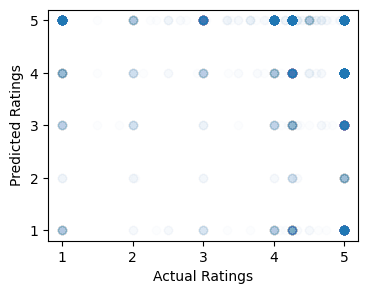

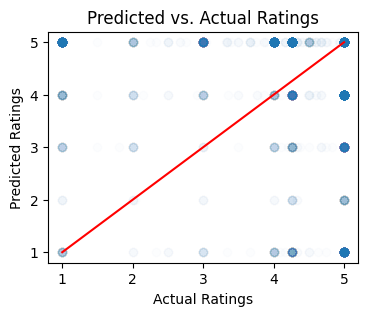

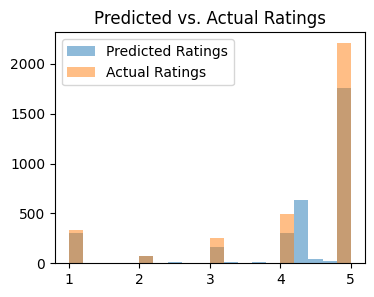

In [55]:
#시각화

# 전체 장소에 대한 예측 평점
all_predictions = model.test(trainset.all_ratings())

# 전체 장소에 대한 실제 평점
all_ratings = trainset.all_ratings()

# 예측 평점과 실제 평점을 분리
predicted_ratings = [prediction.est for prediction in all_predictions]
actual_ratings = [rating[2] for rating in all_ratings]

# 실제평점 반올림
actual_ratings = [round(rating) for rating in actual_ratings]

# 예측 평점과 실제 평점의 상관관계 시각화
plt.figure(figsize=(4, 3))
plt.scatter(predicted_ratings, actual_ratings, alpha=0.01)
plt.ylabel('Predicted Ratings')
plt.xlabel('Actual Ratings')

#시각화
plt.figure(figsize=(4, 3))
plt.scatter(predicted_ratings, actual_ratings, alpha=0.01)
plt.ylabel('Predicted Ratings')
plt.xlabel('Actual Ratings')
plt.plot( [min(actual_ratings), max(actual_ratings)],[min(predicted_ratings), max(predicted_ratings)], color='red')
plt.title('Predicted vs. Actual Ratings')
plt.show()

# 예측평점과 실제평점 분포 시각화
plt.figure(figsize=(4, 3))
plt.hist(predicted_ratings, bins=20, alpha=0.5, label='Predicted Ratings')
plt.hist(actual_ratings, bins=20, alpha=0.5, label='Actual Ratings')
plt.legend()
plt.title('Predicted vs. Actual Ratings')
plt.show()

# 모델 저장


In [57]:
import pickle

pickle.dump(model, open('hscrown-KNN.pkl', 'wb'))